# Fake News Detection

## Importintg the libraries

In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import (classification_report, confusion_matrix,
                             precision_recall_fscore_support, roc_auc_score,
                             RocCurveDisplay, PrecisionRecallDisplay)

from wordcloud import WordCloud
import joblib

In [2]:
# Folders
DATA_DIR   = "data"     # we have saved our data in this folder
PLOTS_DIR  = "plots"    # save all charts/plots here
MODELS  = "models"  # for saved models, vectorizers, etc.

os.makedirs(PLOTS_DIR, exist_ok=True)
os.makedirs(MODELS, exist_ok=True)

In [3]:
# For repratibility
RANDOM_STATE = 42

## Loading the News Detection (Fake or Real) Dataset <a href="https://www.kaggle.com/datasets/nitishjolly/news-detection-fake-or-real-dataset"> (link) </a>

In [4]:
FAKE_PATH = os.path.join(DATA_DIR, "Fake.csv")
TRUE_PATH = os.path.join(DATA_DIR, "True.csv")

print("Fake.csv path : ", FAKE_PATH)
print("True.csv path : ", TRUE_PATH)

Fake.csv path :  data\Fake.csv
True.csv path :  data\True.csv


In [5]:
# Loading the data
df_fake = pd.read_csv(FAKE_PATH)
df_true = pd.read_csv(TRUE_PATH)

print("Columns in Fake.csv:", df_fake.columns.tolist())
print("Columns in True.csv:", df_true.columns.tolist())

Columns in Fake.csv: ['title', 'text', 'subject', 'date']
Columns in True.csv: ['title', 'text', 'subject', 'date']


In [6]:
# Normalize column names
df_fake.columns = [c.strip().lower() for c in df_fake.columns]
df_true.columns = [c.strip().lower() for c in df_true.columns]

In [8]:
# Standardizing types
for d in (df_fake, df_true):
    # Ensure all columns have strings (some CSVs can have NaNs or non-str types)
    d["title"]   = d["title"].astype(str)
    d["text"]    = d["text"].astype(str)
    d["subject"] = d["subject"].astype(str)
    # Parse date, ignore errors to keep bad rows
    d["date"]    = pd.to_datetime(d["date"], errors="coerce")

In [9]:
# Tag labels
df_fake["label_name"] = "fake"
df_true["label_name"] = "real"

In [11]:
df = pd.concat(
    [
        df_fake[["title", "text", "subject", "date", "label_name"]],
        df_true[["title", "text", "subject", "date", "label_name"]],
    ],
    ignore_index=True
)

df.head()

,title,text,subject,date,label_name
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29,fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25,fake


In [12]:
# Turning label names to Numeric label : fake=0, real=1
df["label"] = df["label_name"].map({"fake": 0, "real": 1}).astype(int)
df.head()

,title,text,subject,date,label_name,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,2017-12-31,fake,0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,2017-12-31,fake,0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,2017-12-30,fake,0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,2017-12-29,fake,0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,2017-12-25,fake,0


In [14]:
# Combining features
df["full_text"] = (df["title"].fillna("") + " " +
                   df["subject"].fillna("") + " " +
                   df["text"].fillna("")).str.strip()

print(df.head())

                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject       date  \
0  Donald Trump just couldn t wish all Americans ...    News 2017-12-31   
1  House Intelligence Committee Chairman Devin Nu...    News 2017-12-31   
2  On Friday, it was revealed that former Milwauk...    News 2017-12-30   
3  On Christmas day, Donald Trump announced that ...    News 2017-12-29   
4  Pope Francis used his annual Christmas Day mes...    News 2017-12-25   

  label_name  label                                          full_text  
0       fake      0  Donald Trump Sends Out Embarrassing New Year’s...  
1       fake      0  Drunk Bragging Trump Staffer Started Russian 

In [15]:
print("\nClass balance:\n", df["label_name"].value_counts())


Class balance:
 label_name
fake    23481
real    21417
Name: count, dtype: int64


## Light Text Cleaning

In [16]:
URL_RE      = re.compile(r"https?://\S+|www\.\S+")
EMOJI_RE    = re.compile(r"[\U00010000-\U0010ffff]", flags=re.UNICODE)
MULTI_SPACE = re.compile(r"\s+")

def basic_clean(text: str) -> str:
    if not isinstance(text, str):
        text = str(text)
    text = URL_RE.sub(" ", text) # remove URLs
    text = EMOJI_RE.sub(" ", text) # remove emoji/rare symbols
    text = re.sub(r"[^\w\s]", " ", text)  # drop punctuation
    text = MULTI_SPACE.sub(" ", text) # collapse spaces
    return text.strip().lower()

## Splitting the training and testing set

In [17]:
X = df["full_text"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,            # 80/20 split
    random_state=RANDOM_STATE,
    stratify=y                 # keep class balance similar in both splits
)

len(X_train), len(X_test)

(35918, 8980)

## TF-IDF Vectorizer and Linear SVM classifier

In [18]:
tf_idf = TfidfVectorizer(
    preprocessor=basic_clean,
    stop_words="english",
    ngram_range=(1, 2),
    max_features=100_000,
    lowercase=False 
)

In [20]:
# Fitting the vectorizer on training text, transform both train and test.
X_train_tf_idf = tf_idf.fit_transform(X_train)
X_test_tf_idf  = tf_idf.transform(X_test)

In [21]:
X_train_tf_idf.shape, X_test_tf_idf.shape

((35918, 100000), (8980, 100000))

In [22]:
# Train a Linear SVM (hinge-loss SVM).
svm = LinearSVC(C=1.0, class_weight=None, random_state=RANDOM_STATE) # C controls regularization strength (higher = less regularization).
svm.fit(X_train_tf_idf, y_train)

,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,1.0
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,verbose,0
,random_state,42


## Evilating Accuracy, Precision, Recall, F1, and ROC-AUC

In [23]:
# Predicting on test set
y_pred = svm.predict(X_test_tf_idf)

# Core scores
acc = (y_pred == y_test).mean()
p, r, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {p:.4f}")
print(f"Recall   : {r:.4f}")
print(f"F1-score : {f1:.4f}")

Accuracy : 0.9974
Precision: 0.9974
Recall   : 0.9972
F1-score : 0.9973


In [25]:
print("Classification Report :")
print(classification_report(y_test, y_pred, target_names=["fake", "real"]))

Classification Report :
              precision    recall  f1-score   support

        fake       1.00      1.00      1.00      4696
        real       1.00      1.00      1.00      4284

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



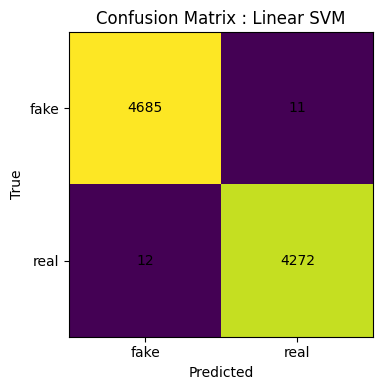

Saved :  plots\svm_confusion_matrix.jpg


In [26]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(cm, interpolation='nearest')
ax.set_title("Confusion Matrix : Linear SVM")
ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
ax.set_xticklabels(["fake", "real"]); ax.set_yticklabels(["fake", "real"])
for (i, j), v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha='center', va='center')
ax.set_xlabel('Predicted'); ax.set_ylabel('True')
plt.tight_layout()

conf_path = os.path.join(PLOTS_DIR, "svm_confusion_matrix.jpg")
plt.savefig(conf_path, dpi=150, bbox_inches="tight")
plt.show()

print("Saved : ", conf_path)

In [27]:
# ROC-AUC and Precision-Recall curves (using decision_function scores)
# SVM doesn't have predict_proba, but it has decision_function (higher = more likely class 1)
scores = svm.decision_function(X_test_tf_idf)

try:
    auc = roc_auc_score(y_test, scores)
    print(f"ROC-AUC: {auc:.4f}")
except Exception as e:
    print("Couldn't compute ROC-AUC:", e)

ROC-AUC: 1.0000


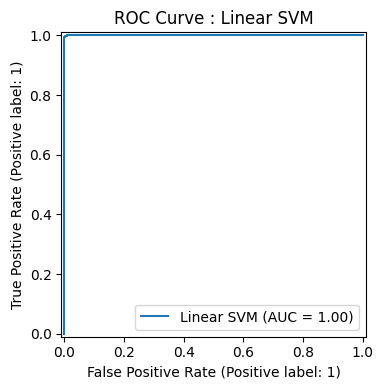

Saved :  plots\svm_roc_curve.jpg


In [29]:
# ROC curve
fig_roc, ax_roc = plt.subplots(figsize=(5,4))
RocCurveDisplay.from_predictions(y_test, scores, ax=ax_roc, name="Linear SVM")
ax_roc.set_title("ROC Curve : Linear SVM")
plt.tight_layout()
roc_path = os.path.join(PLOTS_DIR, "svm_roc_curve.jpg")
plt.savefig(roc_path, dpi=150, bbox_inches="tight")
plt.show()
print("Saved : ", roc_path)

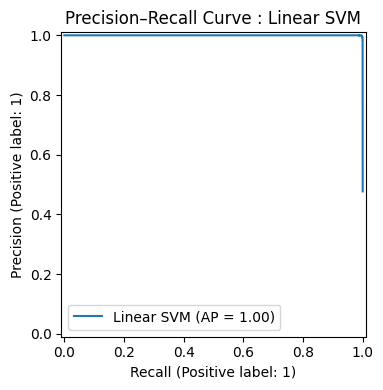

Saved :  plots\svm_precision_recall_curve.jpg


In [30]:
# Precision-Recall curve
fig_pr, ax_pr = plt.subplots(figsize=(5,4))
PrecisionRecallDisplay.from_predictions(y_test, scores, ax=ax_pr, name="Linear SVM")
ax_pr.set_title("Precision–Recall Curve : Linear SVM")
plt.tight_layout()
pr_path = os.path.join(PLOTS_DIR, "svm_precision_recall_curve.jpg")
plt.savefig(pr_path, dpi=150, bbox_inches="tight")
plt.show()
print("Saved : ", pr_path)

## Word clouds for common terms (Fake vs. Real)

In [31]:
# Joining all text in each class
# WordCloud will handle the frequency.
# We generate on the *cleaned* text for best results.

texts_fake = " ".join(df.loc[df["label"] == 0, "full_text"].map(basic_clean).tolist())
texts_real = " ".join(df.loc[df["label"] == 1, "full_text"].map(basic_clean).tolist())

wc_fake = WordCloud(width=1000, height=500, background_color="white",
                    stopwords=set()).generate(texts_fake)
wc_real = WordCloud(width=1000, height=500, background_color="white",
                    stopwords=set()).generate(texts_real)

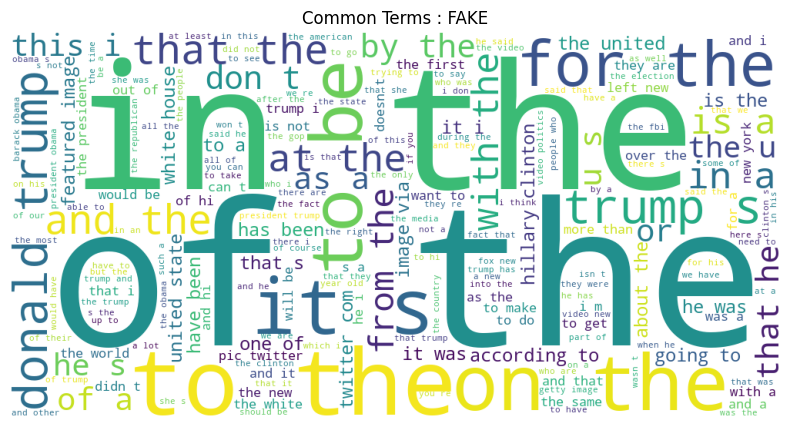

Saved :  plots\wordcloud_fake.jpg


In [32]:
# Plotting WC FAKE
plt.figure(figsize=(10,5))
plt.imshow(wc_fake)
plt.axis("off")
plt.title("Common Terms : FAKE")
fake_wc_path = os.path.join(PLOTS_DIR, "wordcloud_fake.jpg")
plt.savefig(fake_wc_path, dpi=150, bbox_inches="tight")
plt.show()
print("Saved : ", fake_wc_path)

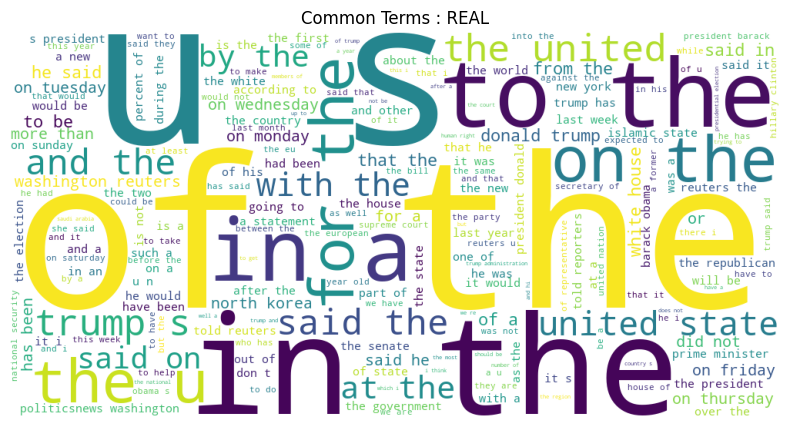

Saved :  plots\wordcloud_real.jpg


In [33]:
# Plotting WC REAL
plt.figure(figsize=(10,5))
plt.imshow(wc_real)
plt.axis("off")
plt.title("Common Terms : REAL")
real_wc_path = os.path.join(PLOTS_DIR, "wordcloud_real.jpg")
plt.savefig(real_wc_path, dpi=150, bbox_inches="tight")
plt.show()
print("Saved : ", real_wc_path)

## Saving the model and vectorizer

In [34]:
model_path = os.path.join(MODELS, "linear_svm_fake_news.joblib")
vect_path  = os.path.join(MODELS, "tf_idf_vectorizer.joblib")

joblib.dump(svm, model_path)
joblib.dump(tf_idf, vect_path)

print("Saved model to : ", model_path)
print("Saved vectorizer to : ", vect_path)

Saved model to :  models\linear_svm_fake_news.joblib
Saved vectorizer to :  models\tf_idf_vectorizer.joblib


## Predicting on new text

In [35]:
def predict_label(text: str):
    X_vec = tf_idf.transform([text])
    pred  = svm.predict(X_vec)[0]
    return "REAL" if pred == 1 else "FAKE"

sample = "Government announces new policy to reduce inflation over the next year."
print("News Sample : ", sample)
print("Prediction : ", predict_label(sample))

News Sample :  Government announces new policy to reduce inflation over the next year.
Prediction :  FAKE
